# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.24.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', as_frame=False, return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

In [4]:
def Q1():
    
### STUDENT START ###
    def blur(data):
        arr = data.reshape(-1,28,28)
        #Adding 0s around original array to handle edge cases
        arr = np.pad(arr, (1,1), 'constant', constant_values=(0))
        filtered_arr = np.zeros(arr.shape)
        #Starting from original first index
        index = 0
        #Iterating through each pixel of each example
        for img in arr:
            row = 1
            while row < len(img) - 1:
                col = 1
                while col < len(img[0]) - 1:
                    #Summing original pixel with 8 neighbouring pixels
                    total = img[row - 1, col + 1] +\
                            img[row, col + 1] +\
                            img[row + 1, col + 1] +\
                            img[row - 1, col] +\
                            img[row, col] +\
                            img[row + 1, col] +\
                            img[row + 1, col - 1] +\
                            img[row, col - 1] +\
                            img[row - 1, col - 1]
                    
                    #Adding pixel smoothed value to filtered_arr
                    filtered_arr[index][row][col] = total/9
                    col +=1 
                row += 1
            index += 1

        #Returning array with padding removed
        return filtered_arr[1:-1,1:-1,1:-1].reshape(data.shape)

    knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
    knn.fit(mini_train_data, mini_train_labels)
    y_pred = knn.predict(dev_data)
    accuracy = sklearn.metrics.accuracy_score(dev_labels, y_pred)
    print(f'Prediction accuracy without filter: {accuracy}')

    knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
    knn.fit(blur(mini_train_data), mini_train_labels)
    y_pred = knn.predict(dev_data)
    accuracy = sklearn.metrics.accuracy_score(dev_labels, y_pred)
    print(f'Prediction accuracy with filter on training data: {accuracy}')
    
    knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
    knn.fit(mini_train_data, mini_train_labels)
    y_pred = knn.predict(blur(dev_data))
    accuracy = sklearn.metrics.accuracy_score(dev_labels, y_pred)
    print(f'Prediction accuracy with filter on dev data: {accuracy}')
    
    knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
    knn.fit(blur(mini_train_data), mini_train_labels)
    y_pred = knn.predict(blur(dev_data))
    accuracy = sklearn.metrics.accuracy_score(dev_labels, y_pred)
    print(f'Prediction accuracy with filter on both training and dev data: {accuracy}')
### STUDENT END ###

Q1()

Prediction accuracy without filter: 0.884
Prediction accuracy with filter on training data: 0.907
Prediction accuracy with filter on dev data: 0.868
Prediction accuracy with filter on both training and dev data: 0.905


Accuracies are highest when the training data is blurred, which reduces the possibility of overfitting in our model.

### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [5]:
def Q2():

### STUDENT START ###
    bnb = BernoulliNB(binarize=0.1)
    bnb.fit(mini_train_data, mini_train_labels)
    print('Prediction accuracy for Bernoulli Naive Bayes: %3.3f' % bnb.score(dev_data, dev_labels))
    
    #Implementing function to trianarize pixel values
    def trianarize(x):
        if x < 0.1:
            return 0
        elif x < 0.9:
            return 1
        else:
            return 2
    
    #Fitting Multinomial Naive Bayes to trianarized data
    mnb = MultinomialNB()
    mnb.fit(np.vectorize(trianarize)(mini_train_data), mini_train_labels)
    print('Prediction accuracy for Multinomial Naive Bayes: %3.3f' % mnb.score(dev_data, dev_labels))    
### STUDENT END ###

Q2()

Prediction accuracy for Bernoulli Naive Bayes: 0.814
Prediction accuracy for Multinomial Naive Bayes: 0.807


ANSWER: The accuracy remains relatively the same, which is not surprising as our implementation of the trianarize function provides very little useful information in addition to binarization of pixel values. In the context of our problem, binarize reduces pixel values to a simple determination of whether or not a pixel is colored in, while the trianarize function adds an additional value in the middle which likely would not help our model classify a digit.

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [6]:
def Q3(alphas):

### STUDENT START ###
    gs = GridSearchCV(BernoulliNB(binarize=0), param_grid=alphas, cv=5, scoring='accuracy')
    gs.fit(mini_train_data, mini_train_labels)
    #Iterating through grid search generated alpha values and corresponding accuracies
    for i, j in zip(gs.cv_results_['params'], gs.cv_results_['mean_test_score']):
        print(f"Alpha: {i['alpha']}  Accuracy: {j:.3f}")
    
### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)


Alpha: 1e-10  Accuracy: 0.814
Alpha: 0.0001  Accuracy: 0.819
Alpha: 0.001  Accuracy: 0.825
Alpha: 0.01  Accuracy: 0.822
Alpha: 0.1  Accuracy: 0.818
Alpha: 0.5  Accuracy: 0.813
Alpha: 1.0  Accuracy: 0.809
Alpha: 2.0  Accuracy: 0.805
Alpha: 10.0  Accuracy: 0.783


ANSWER: The best value for alpha is 0.001 with a mean accuracy score of .825. The accuracy is .814 at the alpha value closest to 0. This lower accuracy is observed as we traverse through ascending values of alpha to determine the optimal alpha for accuracy.

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

Prediction accuracy for base Gaussian Naive Bayes: 0.59
Prediction accuracy for improved Gaussian Naive Bayes: 0.82


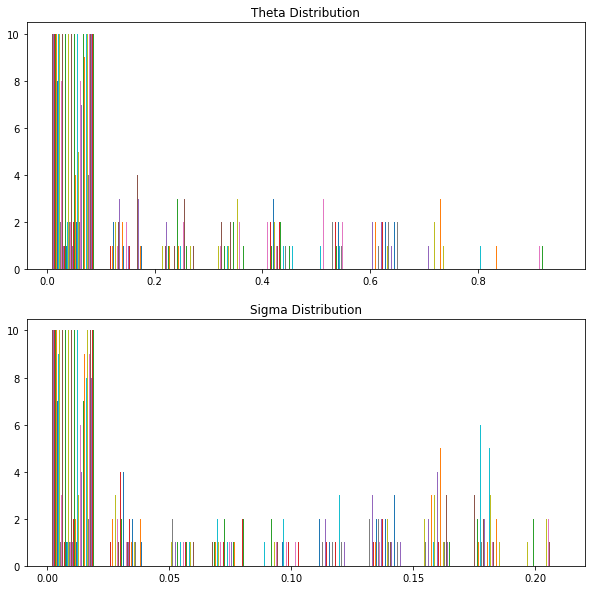

In [7]:
def Q4():

### STUDENT END ###
    gnb = GaussianNB()
    gnb.fit(mini_train_data, mini_train_labels)
    print('Prediction accuracy for base Gaussian Naive Bayes: %3.2f' % gnb.score(dev_data, dev_labels))
    
    #Visualizing theta and sigma
    fig, ax = plt.subplots(2, figsize=(10,10))
    ax[0].hist(gnb.theta_)
    ax[0].title.set_text('Theta Distribution')
    ax[1].hist(gnb.sigma_)
    ax[1].title.set_text('Sigma Distribution')
    
    #Re-fitting Gaussian Naive Bayes model with var_smoothing applied
    gnb = GaussianNB(var_smoothing=0.1)
    gnb.fit(mini_train_data, mini_train_labels)
    print('Prediction accuracy for improved Gaussian Naive Bayes: %3.2f' % gnb.score(dev_data, dev_labels))
### STUDENT END ###

Q4()

ANSWER: The theta and sigma for the Gaussian Naive Bayes model are grouped around 0, which is signaling that many of our conditional probabilities are zeroing out. By applying a nonzero value of var_smoothing, we can approach an accuracy comparable to our Bernoulli Naive Bayes model.

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



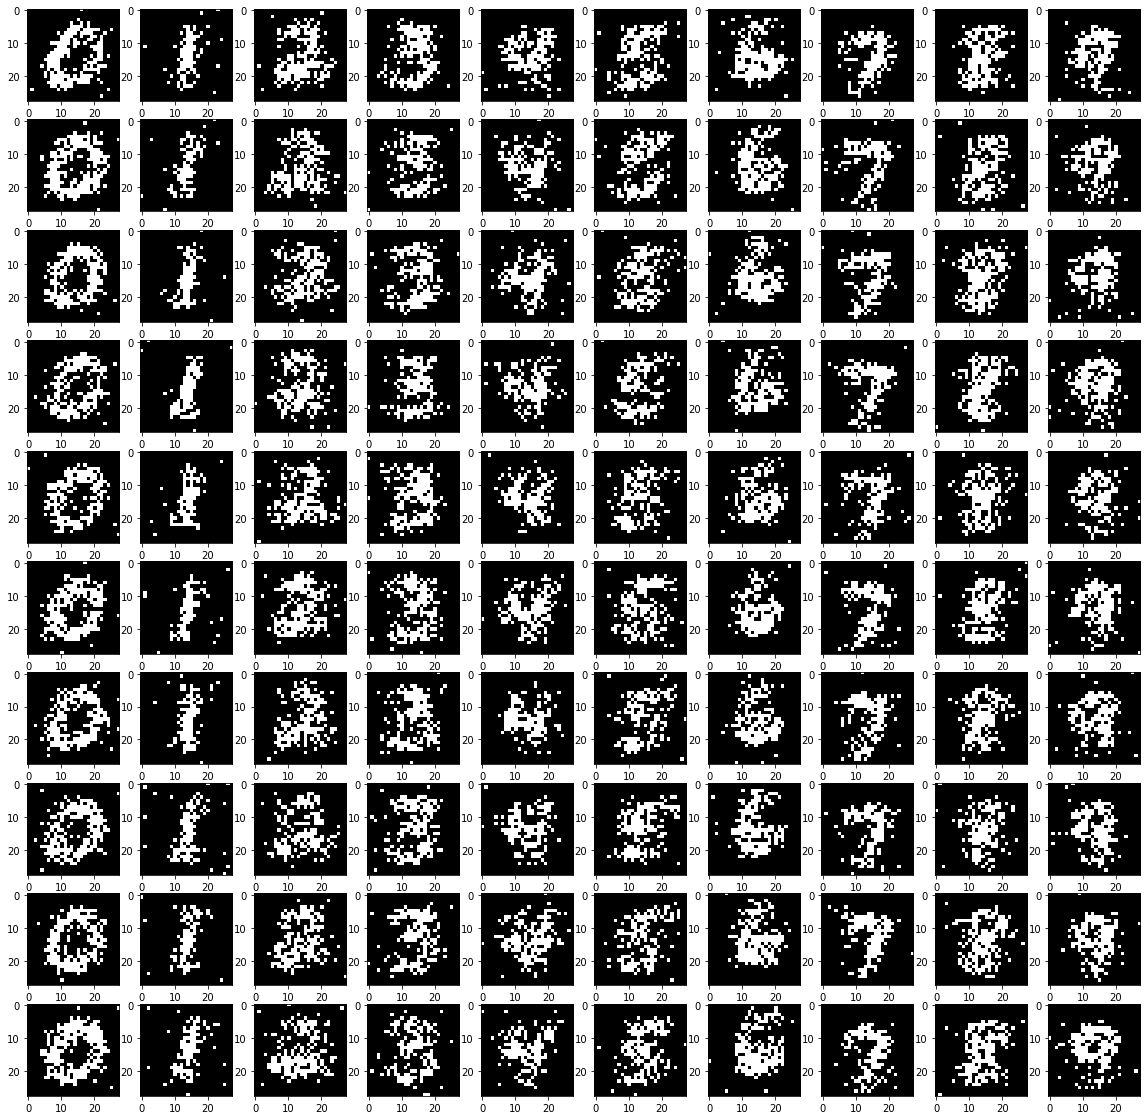

In [8]:
def Q5(num_examples):

### STUDENT START ###
    bnb = BernoulliNB(binarize=0.1)
    bnb.fit(mini_train_data, mini_train_labels)
    #Initializing result array for ten examples of each digit
    res = np.zeros((100,784))
    digit_index = 0
    #Looping through conditional probabilities of BernoulliNB
    for i in range(0,10):
        for digit in np.exp(bnb.feature_log_prob_):
            index = 0
            while index < len(digit):
                #Comparing randomly generated number to estimated conditional probability
                if np.random.rand() < digit[index]:
                    res[digit_index][index] = 1
                else:
                    res[digit_index][index] = 0
                index += 1
            digit_index += 1
        
    def print_digits(data, num_examples=10):
        plt.figure(figsize=(20,20))
        plt.title('Sample of Digits')
        index = 0
        for i in range(0, num_examples):
            for j in range(0, num_examples):
                #Creating a subplot at each ith,jth index
                plt.subplot(num_examples, num_examples, int(str(i) + str(j)) + 1)
                #Indexing train_data for first 10 examples of each digit
                plt.imshow(np.reshape(data[index], (28,28)), cmap=plt.get_cmap('gray'))
                index += 1
    
    print_digits(res, num_examples)
        
### STUDENT END ###

Q5(10)

ANSWER: The generated digit images are significantly grainier due to the process by which the pixel output is generated. As there is a nonzero probability of each pixel being "colored in", pixels around the rough outline of each digit's shape are highlighted. However, as these pixels are generated by comparing against the conditional probabilities from the Bernoulli Naive Bayes, we see that all generated examples still roughly look like our training examples.

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



In [16]:
def Q6(buckets, correct, total):
    
### STUDENT START ###
    bnb = BernoulliNB(binarize=0, alpha=.001)
    bnb.fit(mini_train_data, mini_train_labels)
    print('Prediction accuracy for Bernoulli Naive Bayes: %3.2f' % bnb.score(dev_data, dev_labels))
    
    #Iterating through predicted value and actual value
    for estimate, actual in zip(bnb.predict_proba(dev_data), dev_labels):
        #Determining which bin the estimated posterior probability belongs to
        index = np.digitize(estimate.max(), buckets) - 1
        total[index] += 1
        #Incrementing corresponding "correct" bucket if predicted value and actual value are equivalent
        if estimate.argmax() == int(actual):
            correct[index] += 1
            
    accuracies = [i/j for i,j in zip(correct, total)]
    for bucket, accuracy in zip(buckets, accuracies):
        print(f'Bucket {bucket} has an accuracy of {accuracy:.2f}')
### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

Prediction accuracy for Bernoulli Naive Bayes: 0.82
Bucket 0.5 has an accuracy of 0.35
Bucket 0.9 has an accuracy of 0.43
Bucket 0.999 has an accuracy of 0.46
Bucket 0.99999 has an accuracy of 0.65
Bucket 0.9999999 has an accuracy of 0.77
Bucket 0.999999999 has an accuracy of 0.79
Bucket 0.99999999999 has an accuracy of 0.79
Bucket 0.9999999999999 has an accuracy of 0.84
Bucket 1.0 has an accuracy of 0.94


ANSWER: I would clasify  the model  as being weakly calibrated, as actual accuracy is not equivalent to estimated posterior probability, but does increase as estimated accuracy increses.

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [18]:
def Q7():

### STUDENT START ###

### STUDENT END ###

Q7()

IndentationError: expected an indented block (<ipython-input-18-57d016c02e77>, line 7)